# Scribblings Towards a Learnable Weighted Logic Framework

This notebook contains partial ideas, scribblings and tests in formulating a weighted logic system that is later used as the basis for the neuro-symbolic rule learning.

*It is not meant to make sense as a whole.* It is more of a behind the scenes of the core contribution from the pix2rule paper (https://arxiv.org/abs/2106.07487).

In [2]:
import numpy as np
import pandas as pd
import altair as alt
import tensorflow as tf
import seaborn as sns

## Exploration of weighted AND gate

In this section, I play around with a simple two input, two weights perceptron. I suppose the goal was to find a simpler formulation of conjunction that does not resort to the confines of a t-norm. The inputs and weights are changeable, and for a given formulation, I was seeing how it responded to the input range $[-1,1]$. Here $b$ is the bias, $z$ is the output.

In [3]:
#@title Variables. { run: "auto" }

x = 0  #@param {type: "slider", min: -1, max: 1, step: 1}
y = 1  #@param {type: "slider", min: -1, max: 1, step: 1}
w1 = 3.5  #@param {type: "slider", min: -10, max: 10, step: 0.1}
w2 = 0.7  #@param {type: "slider", min: -10, max: 10, step: 0.1}
#k = 1 #@param {type: "slider", min: -10, max: 10, step: 0.1}

inputs = tf.constant([x,y], dtype=tf.float32)
k = tf.reduce_mean(tf.math.abs(inputs))
print("K:", k)
weights = tf.constant([w1, w2], dtype=tf.float32)
#b = tf.math.atanh(k) - k*(w1+w2)
abs_sum = tf.reduce_sum(tf.math.abs(weights))
#b = k - abs_sum*k
b = -tf.reduce_max(weights)*k
print("B:", b)
z = tf.nn.tanh(tf.reduce_sum(inputs*weights) + b)
print("Z:", z)
print("---")
print(b >= k-abs_sum)
print((w1 + b) < k)
print((w2 + b) < k)
print(b < k)

K: tf.Tensor(0.5, shape=(), dtype=float32)
B: tf.Tensor(-1.75, shape=(), dtype=float32)
Z: tf.Tensor(-0.78180635, shape=(), dtype=float32)
---
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)


## The Weighted Gate and Learnable Atom

Putting together some of the early ideas above, I was experimenting with learnable version. If there is some hope for setting a bias as a threshold for achieving a conjunction, then we should be able to learn the weights of the connections. This leads to a weighted gate, a naive learnable gate with a controllable bias to elicit the desired gate $\land, \lor$ behaviour. It is the precursor to the more polished semi-symbolic layer.

The learnable atom is follows the idea that we can also train the inputs. Suppose we have a conjunction with an output of 1, then we know both inputs should be 1 too. So after training a weighted gate to behave like a conjunction, I was playing with the idea of learning inputs and see if it was behaving properly. This was to fulfill the requirement of potentially having upstream networks such as CNNs which would be trained as well.

But something was amiss. I couldn't formulate a clean, elegant version. I knew something was going on with the bias and it was key ingreadient. So when playing around with this setup, I decided to just train a regular perceptron / linear layer to learn conjunction over randomly generated data. (read next part to see what happens)

In [4]:
class LearnableAtom(tf.keras.layers.Layer):
    """Learnable inputs."""
    def __init__(self, size: int, **kwargs):
        super().__init__(**kwargs)
        self.size = size
        self.atoms = self.add_weight(
            name='weights',
            shape=(size,),
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.00)
        )

    def call(self, inputs, **kwargs):
        """Append weight to inputs."""  
        # inputs (B, X)
        atoms = tf.nn.tanh(self.atoms) # (size,)
        batch_atoms = tf.repeat(atoms[None], tf.shape(inputs)[0], axis=0) # (B, size)
        return tf.concat([inputs[:, :-self.size], batch_atoms], -1) # (B, X)

def binary_entropy(tensor: tf.Tensor):
    """Compute binary entropy of a given tensor."""
    # (...)
    tensor = tf.clip_by_value(tensor, 0.00001, 0.99999)
    merged = tf.stack([tensor, 1-tensor], -1) # (..., 2)
    entropy = -tf.reduce_sum(merged*tf.math.log(merged), -1) # (...)
    return entropy

class WeightedGate(tf.keras.layers.Layer):
    """Weighted conjunction or disjunction layer."""
    def __init__(self, gate_type: str = "AND", **kwargs):
        super().__init__(**kwargs)
        self.gate_type = gate_type

    def build(self, input_shape: tf.TensorShape):
        """Add layer weights."""
        self.kernel = self.add_weight(
            name='kernel',
            shape=(input_shape[-1],)
        )
    
    def call(self, inputs, **kwargs):
        """Forward pass"""
        # Inputs (B, 2)
        conjunct = tf.reduce_sum(inputs*self.kernel, -1) # (B,)
        in_abs_mean = tf.reduce_mean(tf.math.abs(inputs), -1) # (B,)
        wsum = tf.reduce_sum(tf.math.abs(self.kernel)) # ()
        #bias = tf.reduce_max(tf.math.abs(self.kernel))*(self.kernel.shape[-1]-1) # ()
        k = in_abs_mean * 5
        k = 5
        if self.gate_type == 'AND':
            bias = k - wsum
        else:
            bias = wsum - k
        self.add_metric(bias, name='bias')
        return tf.nn.tanh(conjunct + bias)

gate_type = "AND"
in_size = 6

model = tf.keras.Sequential([tf.keras.layers.Dense(1, activation='tanh')])
#model = tf.keras.Sequential([WeightedGate(gate_type=gate_type)])
#model = tf.keras.Sequential([LearnableAtom(size=in_size-2), WeightedGate(gate_type=gate_type)])
model.compile(optimizer='adam', loss='hinge')


rnds = np.random.choice([-1,1], size=(100000, in_size))
if gate_type == "AND":
    success_case = np.array([1]*60)
    success_case = np.random.choice([-1,1], size=(in_size,))
    print(success_case)
    neg_idxs = np.flatnonzero(np.any(rnds != success_case, -1))
    inputs = np.concatenate([np.tile(success_case[None], [len(neg_idxs), 1]), rnds[neg_idxs]])
    #inputs = np.tile(success_case[None], [50000, 1])
    np.random.shuffle(inputs)
    targets = np.all(inputs == success_case, -1)
elif gate_type == "OR":
    #fail_case = np.array([1, 0, 1, 1, 0, 1])
    fail_case = np.random.choice([-1,1], size=(in_size,))
    print(fail_case)
    pos_idxs = np.flatnonzero(np.any(rnds != fail_case, -1))
    inputs = np.concatenate([np.tile(fail_case[None], [len(pos_idxs), 1]), rnds[pos_idxs]])
    np.random.shuffle(inputs)
    targets = np.any(inputs != fail_case, -1)
#inputs = np.concatenate([inputs, 1-inputs], -1)
print("Targets:", np.unique(targets, return_counts=True))
#rands = np.random.randint(-1, 1, size=len(inputs))
#inputs = np.concatenate([inputs, rands[:, None]], -1)
inputs = inputs.astype(np.float32)
print(inputs[:10])
print(targets[:10])
print(model(inputs[:10]))

model.fit(inputs, targets, epochs=5)

[-1  1  1  1  1  1]
Targets: (array([False,  True]), array([98422, 98422]))
[[ 1. -1.  1.  1.  1.  1.]
 [ 1.  1. -1.  1.  1. -1.]
 [ 1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1. -1.  1.  1.]
 [-1.  1. -1.  1.  1. -1.]
 [-1.  1.  1.  1.  1.  1.]
 [-1. -1.  1. -1.  1.  1.]
 [-1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1. -1.  1.  1.]
 [ 1. -1.  1. -1. -1.  1.]]
[False False False False False  True False  True False False]
tf.Tensor(
[[ 0.38922578]
 [ 0.64359933]
 [ 0.9356103 ]
 [ 0.9385686 ]
 [-0.11534204]
 [ 0.00795163]
 [ 0.3526999 ]
 [ 0.00795163]
 [ 0.9385686 ]
 [ 0.11534204]], shape=(10, 1), dtype=float32)
Epoch 1/5
6152/6152 [==============================] - 8s 1ms/step - loss: 0.2150
Epoch 2/5
6152/6152 [==============================] - 7s 1ms/step - loss: 0.0581
Epoch 3/5
6152/6152 [==============================] - 7s 1ms/step - loss: 0.0300
Epoch 4/5
6152/6152 [==============================] - 7s 1ms/step - loss: 0.0156
Epoch 5/5
6152/6152 [==============================] - 7s 1ms/step - l

So we know a linear layer can model conjunction, but what is the key ingredient that allows it to do so. Because I did not want to restrict the weights and had a hunch the bias would do the trick, I focused on the bias of a linear layer that has been trained on AND and OR data.

In [ ]:
model.get_weights()

[array([[-2.347875 ],
        [-2.3537643],
        [-2.3534436],
        [ 2.3352349],
        [-2.3527102],
        [-2.3574061]], dtype=float32), array([-11.024802], dtype=float32)]

It seems to converge to something along the lines of $\sum |w_i| - w_i$ where $w_i$ is one of the weights which all seem to of equal magnitude. But if I was to learn rules, the magnitude would naturally change and there would be more noise than a clean conjunction dataset used here.

In [ ]:
tensor = tf.constant([0.6, 0.5])
ttensor = tensor*2-1
print(binary_entropy(tensor))
print(1-tf.square(ttensor))

tf.Tensor([0.67301166 0.6931472 ], shape=(2,), dtype=float32)
tf.Tensor([0.96 1.  ], shape=(2,), dtype=float32)


I was keen to regularise the model so far using entropy to get a clearer picture and was tempted to modify weights instead of the bias for a second (a second here is actually a week or two :) ) But restricting the weights would restrict the learning, particularly of upstream parts of the network making an end-to-end learning setup more difficult. So I decided to focus back on the bias.

In [ ]:
np.abs(model.get_weights()[0]).sum()


14.100435

There was something about the absolute value sum of the weights and that acting as a threshold. *I'm sure this is an obvious relation that cleverer people would have known about* but for me it was a slow and steady exploration.

In [7]:
inputs = np.array([[1,0,1]])
inputs = np.concatenate([inputs, 1-inputs], -1)
model(inputs)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.]], dtype=float32)>

## Towards Semi-symbolic Layer

Taking the previous observations forward, I spent time trying to *elegantly* formulate the above failures and findings. At the this stage, I knew something was up with the bias and some thresholding value but it wasn't easy as setting it to a fixed value assuming the weights were trained. That's easy. *The trick was to formulate a simple solution that is robust to training.*

You will find many different attempts (some even deleted, overwritten) that eventually led to the semi-symbolic layer used in the project.

In [8]:
def conjunction(tensor: tf.Tensor, kernel: tf.Tensor, threshold: float):
    """Compute conjunction of given inputs at a certain threshold."""
    # tensor (..., H), kernel (H,)
    tanh_kernel = tf.nn.tanh(kernel)
    #and_weights = tanh_kernel * threshold / tf.nn.tanh(threshold)
    and_weights = tanh_kernel*6
    #print(and_weights)
    and_wsum = 1 - tf.reduce_sum(tf.math.abs(tanh_kernel), -1)  # ()
    and_bias = threshold * and_wsum  # ()
    #print(and_bias)
    conjunct_eval = tensor*and_weights # (..., H)
    #print(conjunct_eval)
    conjuncts = tf.reduce_sum(conjunct_eval, -1) + and_bias  # (...)
    #print(conjuncts)
    conjuncts = tf.nn.tanh(conjuncts)  # (...)
    return conjuncts, and_bias

def conjunction2(tensor: tf.Tensor, kernel: tf.Tensor, threshold: float, scale:float=1.0):
    """Compute conjunction of given elements."""
    # tensor (..., H), kernel (H,)
    abs_kernel = tf.math.abs(kernel) # (H,)
    and_bias = tf.reduce_max(abs_kernel, -1)*scale - tf.reduce_sum(abs_kernel) # ()
    conjuncts = tf.reduce_sum(tensor * kernel, -1) + threshold*and_bias
    return tf.nn.tanh(conjuncts), and_bias
    
def conjunction3(tensor: tf.Tensor, kernel: tf.Tensor, threshold: float, scale:float=1.0):
    """Compute conjunction of given elements."""
    # tensor (..., H), kernel (H,)
    abs_kernel = tf.math.abs(kernel) # (H,)
    and_bias = tf.reduce_mean(abs_kernel, -1)*scale - tf.reduce_sum(abs_kernel) # ()
    conjuncts = tf.reduce_sum(tensor * kernel, -1) + threshold*and_bias
    return tf.nn.tanh(conjuncts), and_bias

def disjunction2(tensor: tf.Tensor, kernel: tf.Tensor, threshold: float):
    """Compute disjunction of given elements."""
    # tensor (..., H), kernel (H,)
    abs_kernel = tf.math.abs(kernel) # (H,)
    or_bias = tf.reduce_sum(abs_kernel, -1) - tf.reduce_max(abs_kernel, -1) # ()
    res = tf.reduce_sum(tensor * kernel, -1) + threshold*or_bias
    return tf.nn.tanh(res), or_bias

def co_disjunction(tensor: tf.Tensor, kernel: tf.Tensor, threshold:float):
    res, bias = conjunction2(-tensor, kernel, threshold)
    return -res, bias

pre_alpha = 1.00
and_kernel = tf.Variable(tf.constant([1.0, 0.3])*4)
#and_kernel = tf.Variable(tf.constant([-0.0,  5.53147]))
in_tensor = tf.Variable(tf.constant([[1.0, 1.0], [-1.0, 1.0], [1.0, -1.0], [-1.0, -1.0]]))
conjunction3(in_tensor, and_kernel, pre_alpha)

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.98902744, -0.9999593 ,  0.19737533, -0.99999964], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.6>)

## No man's land

One thing many people overlook when formulating fuzzy logic is what happens when the values are not at the extremes. It's relatively easy to propose and use formulations that behave well whent he inputs are true, false. But what happens when they are in between.

For the above formulations, they seem to work okay when the input tensor `in_tensor` contained values from ${-1,1}$. But to differentiate them and more importantly understand their behaviour, I decided to plot and visually explore what is going on.

**Why are the values in between important?** Because when learning end-to-end, most of the time will be spent in this continuous range as opposed to the extremes. Learning features then learning predicates and finally the rules, we need a robust mechanism that behaves well.

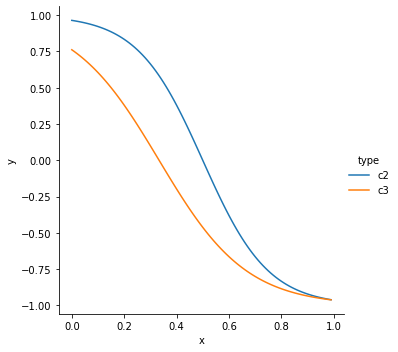

In [9]:
plot_vals = {'x': list(), 'y': list(), 'type': list()}
for i in np.arange(0.0, 1.0, 0.01):
    and_kernel = tf.constant([1.0, i])*2
    for ctype, func in [('c2', conjunction2), ('c3', conjunction3)]:
        plot_vals['x'].append(i)
        res = func(in_tensor, and_kernel, pre_alpha)
        plot_vals['y'].append(res[0][2].numpy())
        plot_vals['type'].append(ctype)
plot_vals = pd.DataFrame(plot_vals)
sns.relplot(x='x', y='y', hue='type', kind='line', data=plot_vals)

Here are some comparisons between different conjunction methods and different scales / delta values. I played around with it more and this is just the last state of affairs.

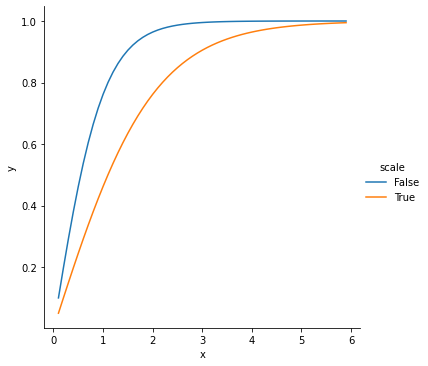

In [ ]:
plot_vals = {'x': list(), 'scale': list(), 'y': list()}
for i in np.arange(0.1, 6, 0.1):
    and_kernel = tf.constant([1.0, 1.0])*i
    for scale in [1.0, 0.5]:
        res, _ = conjunction2(in_tensor, and_kernel, 1.0, scale=scale)
        plot_vals['scale'].append(scale == 0.5)
        plot_vals['y'].append(res[0].numpy())
        plot_vals['x'].append(i)
plot_vals = pd.DataFrame(plot_vals)
sns.relplot(x='x', y='y', hue='scale', kind='line', data=plot_vals)

### Gradual bias

The following plot demonstrates how we can gradually adjust this bias value to make the layer behave like a conjunction. Since when the bias is 0, the layer is identical to a linear layer, it showed promise to be used in a larger network with upstream components. As we are training, *why not gradually adjust this?* That's exactly what we did.

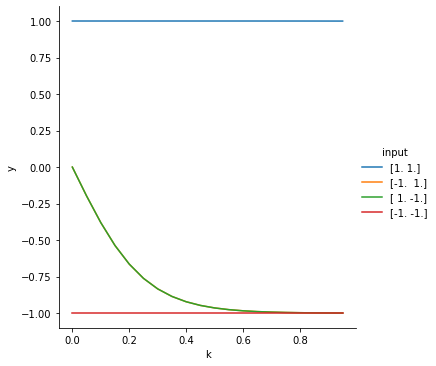

In [ ]:
plot_vals = {}
for k in np.arange(0.00, 1, 0.05):
    and_kernel = tf.constant([4.0, 4.0])
    res, _ = conjunction2(in_tensor, and_kernel, k)
    res = res.numpy()
    for j in np.arange(res.size):
        plot_vals.setdefault('y', []).append(res[j])
        plot_vals.setdefault('input', []).append(str(in_tensor[j].numpy()))
        plot_vals.setdefault('k', []).append(k)
plot_vals = pd.DataFrame(plot_vals)
sns.relplot(x='k', y='y', hue='input', kind='line', data=plot_vals)

Another exploration involved the gradient of the inputs. I still was not sure if it would be able to learn upstream components such as CNNs if for example we started to restrict the layer to behave like a conjunction early on. The following are just gradient plots to see what is going on.

tf.Tensor([-0.00182765  0.00245886], shape=(2,), dtype=float32) tf.Tensor(
[[-1.5484687e-04 -4.6454064e-05]
 [-1.1567799e-02 -3.4703400e-03]
 [-1.8628052e-02 -5.5884155e-03]
 [ 9.5484364e-05  2.8645311e-05]], shape=(4, 2), dtype=float32)
tf.Tensor([-0.00369557  0.0052021 ], shape=(2,), dtype=float32) tf.Tensor(
[[-1.9692405e-04 -5.9077218e-05]
 [-9.1108233e-03 -2.7332471e-03]
 [-2.3620829e-02 -7.0862491e-03]
 [ 7.5338852e-05  2.2601656e-05]], shape=(4, 2), dtype=float32)
tf.Tensor([-0.00576677  0.00840935], shape=(2,), dtype=float32) tf.Tensor(
[[-2.4984707e-04 -7.4954121e-05]
 [-7.1737394e-03 -2.1521219e-03]
 [-2.9931605e-02 -8.9794816e-03]
 [ 5.9365346e-05  1.7809605e-05]], shape=(4, 2), dtype=float32)
tf.Tensor([-0.00815313  0.01235225], shape=(2,), dtype=float32) tf.Tensor(
[[-3.18025093e-04 -9.54075294e-05]
 [-5.64753078e-03 -1.69425935e-03]
 [-3.78954299e-02 -1.13686295e-02]
 [ 4.66102902e-05  1.39830872e-05]], shape=(4, 2), dtype=float32)
tf.Tensor([-0.01098014  0.01735216], sha

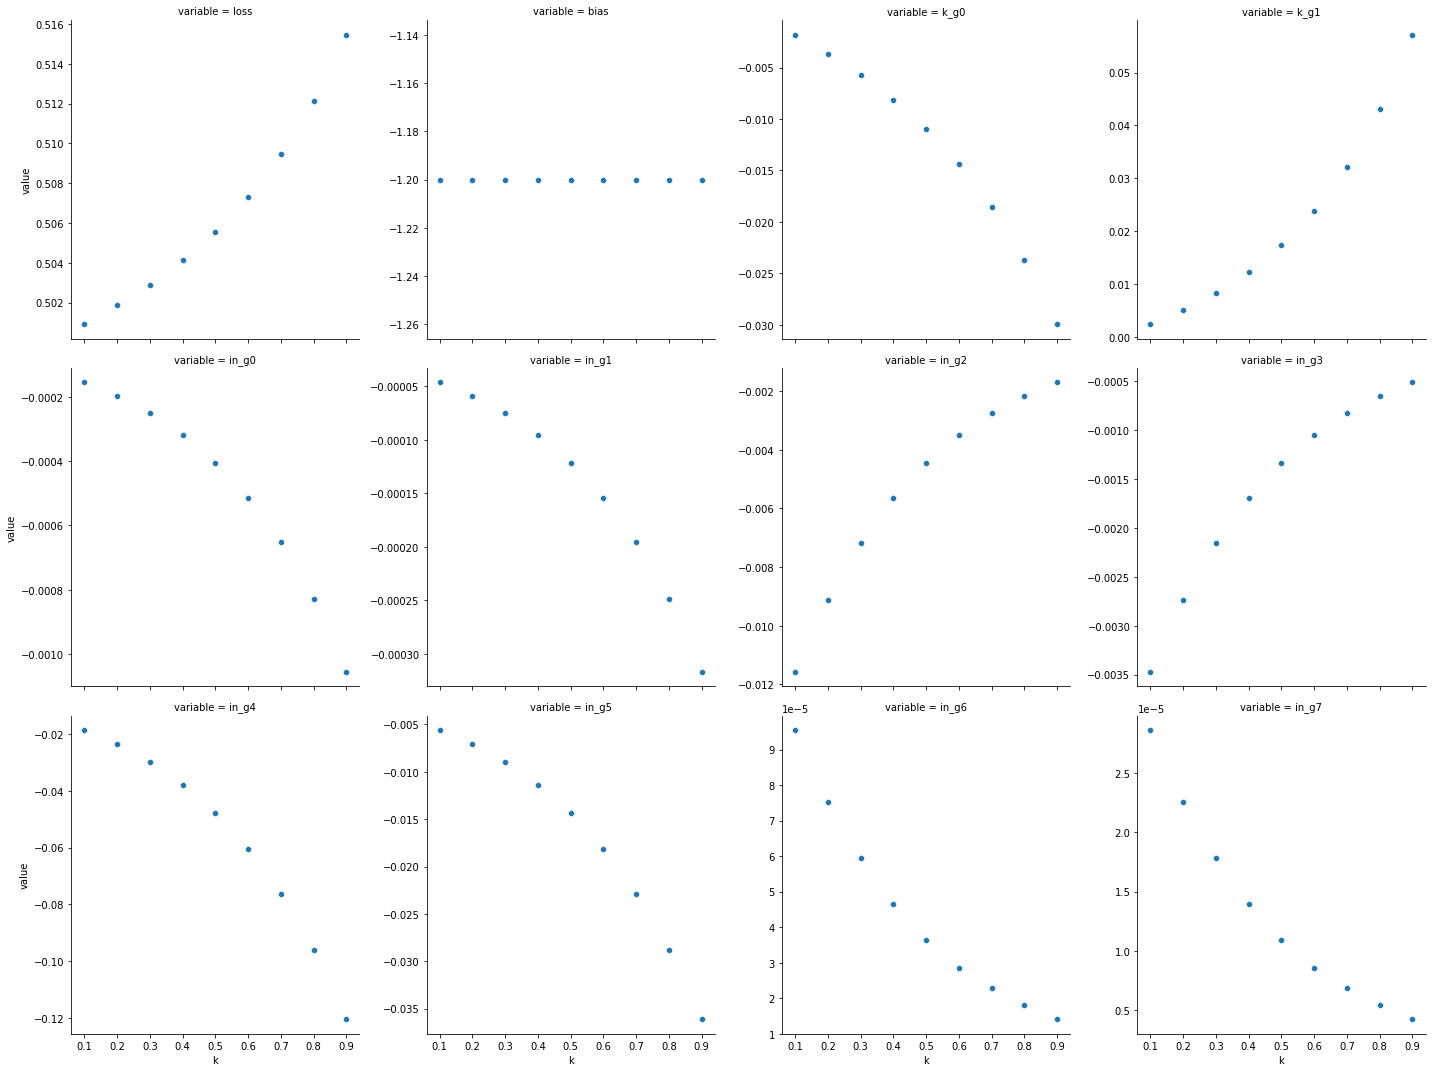

In [17]:
target = tf.constant([1, 1, 1, -1])
in_tensor = tf.Variable(tf.constant([[1.0, 1.0], [-1.0, 1.0], [1.0, -1.0], [-1.0, -1.0]]))
and_kernel = tf.Variable(tf.constant([1.0, 0.3])*4)
k_values = np.arange(0.1, 1, 0.1, dtype=np.float32)
k_losses = list()
k_bias = list()
k_gradients = list()
in_gradients = list()
for k in k_values:
    with tf.GradientTape() as tape:
        preds, and_bias = conjunction2(in_tensor, and_kernel, k)
        loss = tf.keras.losses.hinge(target, preds)
    kernel_g, in_g = tape.gradient(loss, [and_kernel, in_tensor])
    in_g = tf.reshape(in_g, (-1,))
    k_gradients.append(kernel_g)
    in_gradients.append(in_g)
    k_losses.append(loss)
    k_bias.append(and_bias)
k_losses = np.array(k_losses)
k_gradients = np.array(k_gradients)
in_gradients = np.array(in_gradients)
k_bias = np.array(k_bias)
d_dict = {'k': k_values, 'loss': k_losses, 'bias': k_bias}
for i in range(k_gradients.shape[1]):
    d_dict[f'k_g{i}'] = k_gradients[:, i]
for i in range(in_gradients.shape[1]):
    d_dict[f'in_g{i}'] = in_gradients[:, i]
dframe = pd.DataFrame(d_dict)
dframe = pd.melt(dframe, id_vars='k')
sns.relplot(x='k', y='value', col='variable', col_wrap=4, facet_kws={'sharey': False, 'sharex': True}, data=dframe)

## Failed disjunction

This was another side-quest in trying to bound the weights using tanh. While the above formulation was closer to that of a linear layer, it was unbounded and difficult to interpret. When trained, there wasn't a direct way of understanding the magnitude of the weights. So here, a small attempt was to bound the weights using tanh as well, but restricting the weights as mentioned before, hampered learning.

In [18]:
def disjunction(tensor: tf.Tensor, kernel: tf.Tensor, threshold: float):
    """Compute weighted disjunction of given inputs at a certain threshold."""
    # tensor (..., H), kernel (H,)
    tanh_kernel = tf.nn.tanh(kernel)  # (H,)
    or_weights = (
        tanh_kernel
        * threshold
        / tf.nn.tanh(threshold)
    )  # (H,)
    kernel_sum = tf.reduce_sum(tf.math.abs(tanh_kernel), -1) - 1  # ()
    disj_bias = kernel_sum * threshold  # (RX,)
    disj = (
        tf.reduce_sum(tensor * or_weights, -1) + disj_bias
    )  # (B, ..., RX)
    return disj
pre_alpha = 6.00
or_kernel = np.array([tf.math.atanh(0.5), 7.90682, 7.5999 ], dtype=np.float32)
#or_kernel = tf.constant([-1.0, 1.0]*19 + [-1.0, 1.0])*pre_alpha
#in_tensor = tf.constant([[1.0, 1.0], [-1.0, 1.0], [1.0, -1.0], [-1.0, -1.0]])
#in_tensor = tf.constant([1.0,-1.0]*20)
in_tensor = tf.constant([1.0, -1.0, -1.0])
disjunction(in_tensor, or_kernel, pre_alpha)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.00011253357>

In [19]:
pre_alpha = 6.00
or_kernel = tf.constant([[-1.39,-1.27,-0.91,-1.18,-0.71,-0.96,-0.97,-1.34],
 [ 1.18, 0.94, 0.6 , 1.09, 0.73,-0.81, 0.7 , 0.76],
 [ 0.  , 0.99, 0.77, 0.7 , 0.84, 0.77, 1.09, 0.76],
 [ 0.75, 1.4 , 0.82, 0.65, 0.  , 0.79, 0.  , 0.84]])
in_tensor = np.array([[[[-0.14315,  0.96605,  0.96558,  0.62979,  0.48423,  0.83906,  0.27991,  0.98363],
         [-0.98642, -0.99877, -0.99847, -0.99187, -0.98435, -0.99993, -0.96311, -0.60664],
         [-0.99969,  0.99423,  0.76752,  0.98772, -0.84165, -0.98961,  0.94269,  0.99059],
         [-0.55655, -0.9964 ,  0.81429, -0.99452,  0.98392,  0.80459, -0.98978,  0.8857 ]],

        [[ 0.82278,  0.85885,  0.9803 ,  0.93879,  0.81001,  0.35316, -0.32796,  0.98942],
         [-0.99523, -0.99915, -0.99455, -0.91039, -0.81681, -0.99655, -0.99692,  0.26062],
         [ 0.94675, -0.95318, -0.99127,  0.80519,  0.97603,  0.27773, -0.99944, -0.92331],
         [-0.85248, -0.90856,  0.98953,  0.27601, -0.99934,  0.82296, -0.989  , -0.99986]]],


       [[[ 0.26639, -0.98558, -0.01491, -0.30482, -0.95428, -0.99519, -0.96259, -0.78745],
         [ 0.99574,  0.81324,  0.94441, -0.98715,  0.25731, -0.99999, -0.9581 , -0.91976],
         [-0.9984 , -0.96708, -0.99932,  0.01094, -0.95271, -0.99864, -0.99937, -0.97461],
         [ 0.38653, -0.84549,  0.90454, -0.97819, -0.92525,  0.82584, -0.96892, -0.99263]],

        [[ 0.23114,  0.99771,  0.96252, -0.1702 ,  0.95645,  0.99231,  0.89215,  0.99008],
         [-0.92271, -0.93723, -0.99728,  0.85294,  0.65302, -0.99797,  0.62944,  0.99593],
         [-0.99995, -0.90932, -0.9984 , -0.08316, -0.9546 , -0.99981, -0.99841, -0.55042],
         [ 0.29543, -0.31071,  0.94717, -0.99083, -0.56219,  0.98912, -0.99438, -0.78261]]],


       [[[-0.82906, -0.26135, -0.17366, -0.65341, -0.96061, -0.80802, -0.8125 , -0.09048],
         [-0.06078,  0.94288, -0.67384, -0.99369,  0.05594, -0.99908, -0.9327 , -0.65743],
         [-0.87492,  0.128  , -0.83881,  0.97367,  0.56524, -0.93507, -0.49139,  0.67477],
         [-0.901  , -0.99791, -0.40735, -0.96237, -0.99246, -0.47764, -1.     , -0.99968]],

        [[-0.82616, -0.22848, -0.15605, -0.62105, -0.93721, -0.78818, -0.72783, -0.04234],
         [-0.47886,  0.91901, -0.8499 , -0.99341, -0.05369, -0.99823, -0.88616, -0.56129],
         [-0.89372,  0.00046, -0.90612,  0.97617,  0.60388, -0.95179, -0.492  ,  0.69684],
         [-0.86535, -0.9979 , -0.28637, -0.95511, -0.99094, -0.40967, -1.     , -0.99965]]]], dtype=np.float32)
in_tensor = tf.reduce_max(in_tensor, 1)
mask = tf.cast(in_tensor > 0, tf.float32)
in_tensor = mask - (1-mask)

In [20]:
disjunction(in_tensor, or_kernel, pre_alpha)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-6.0004654,  9.727797 , 51.352592 , 25.091576 ],
       [ 3.9290771, 59.216827 ,  1.2521477, 17.623524 ],
       [69.13106  , 18.33443  , 26.263437 , -6.000305 ]], dtype=float32)>

# Threshold and Prune

I wanted to be able to extract the rules after the learning is complete. While the unbounded weights were working, there needed to be a way of extracting the symbolic counterpart. Afterall, the formulation of the bias was enforcing either a conjuntion or disjunction behaviour.

But this proved more difficult because the magnitude of the weights were uneven and non-uniform. After many many different methods, I decided to converge to the simplest: threshold and then prune the weights against a validation dataset. Other methods included sampling based on magnitude, least general generaliser, another inner optimsation to find the best pruning etc. They were more costly than just thresholding too. I validated all these against the prediction accuracy although that is not shown here.

In [21]:
 def threshold_weight(weight: tf.Tensor, threshold: float = 0.01, constant_value: float = 1.0):
        """Threshold given weight by setting it to the given constant value."""
        # weight (...)
        # We will set positive entries to constant_value and
        # negative values to -constant value
        pos_mask = tf.cast(weight > threshold, tf.float32)
        neg_mask = tf.cast(weight < -threshold, tf.float32)
        new_weight = pos_mask * constant_value - neg_mask * constant_value
        # ---------------------------
        return new_weight
print(or_kernel)
threshold_or_kernel = threshold_weight(or_kernel, constant_value=6.0)
print(threshold_or_kernel)
disjunction(in_tensor, threshold_or_kernel, pre_alpha)

tf.Tensor(
[[-1.39 -1.27 -0.91 -1.18 -0.71 -0.96 -0.97 -1.34]
 [ 1.18  0.94  0.6   1.09  0.73 -0.81  0.7   0.76]
 [ 0.    0.99  0.77  0.7   0.84  0.77  1.09  0.76]
 [ 0.75  1.4   0.82  0.65  0.    0.79  0.    0.84]], shape=(4, 8), dtype=float32)
tf.Tensor(
[[-6. -6. -6. -6. -6. -6. -6. -6.]
 [ 6.  6.  6.  6.  6. -6.  6.  6.]
 [ 0.  6.  6.  6.  6.  6.  6.  6.]
 [ 6.  6.  6.  6.  0.  6.  0.  6.]], shape=(4, 8), dtype=float32)


<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-6.000595 , 17.999405 , 77.99948  , 41.999554 ],
       [ 5.999405 , 89.999405 ,  5.999481 , 29.999554 ],
       [89.999405 , 29.999405 , 41.99948  , -6.0004463]], dtype=float32)>

# Conclusion

I hope this notebook demonstrates that often the final version in the paper comes with many failed attemps and frustrations. I used this notebook and tested small ideas for at least 6 months. I hope you find it helpful too.